In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
train_df = pd.read_csv("./dataset/Google_Stock_Price_Train.csv")
training_set = train_df.iloc[:, 1:2].values    # .loc[row,column]

In [3]:
# transform with minmax scaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# create data structure with 60 timesteps and 1 output (t-60)
X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0]) # price from 60 prev timesteps
    y_train.append(training_set_scaled[i, 0]) # price at time t i.e target

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape
## input shape (batch_size, timesteps, input_dim) see keras documentation for RNN input shapes
## input_dim: number of indicators
X_train = np.reshape(X_train, (
    X_train.shape[0], # number of observation
    X_train.shape[1], # number of timestep or columns 
    1                 # number of indicators/predictors
)) 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [6]:
# initialize regressor
regressor = Sequential()

# add layer
regressor.add(LSTM(
    units=50,
    return_sequences=True, # set to true because we are going to add extra layers
    input_shape=(X_train.shape[1],1) # timestep and indicators
))

regressor.add(Dropout(0.2))  # dropout to prevent overfitting

# add 2nd LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add 3rd LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add 4th LSTM layer (final)
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# add output
regressor.add(Dense(units=1))

# compile RNN
regressor.compile(optimizer="adam", loss="mean_squared_error")


In [7]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 32s 216ms/step - loss: 0.0835
Epoch 2/100
38/38 [==============================] - 7s 189ms/step - loss: 0.0055
Epoch 3/100
38/38 [==============================] - 7s 193ms/step - loss: 0.0062
Epoch 4/100
38/38 [==============================] - 7s 193ms/step - loss: 0.0050
Epoch 5/100
38/38 [==============================] - 7s 192ms/step - loss: 0.0062
Epoch 6/100
38/38 [==============================] - 7s 179ms/step - loss: 0.0053
Epoch 7/100
38/38 [==============================] - 7s 194ms/step - loss: 0.0052
Epoch 8/100
38/38 [==============================] - 8s 218ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 8s 214ms/step - loss: 0.0044
Epoch 10/100
38/38 [==============================] - 8s 206ms/step - loss: 0.0054
Epoch 11/100
38/38 [==============================] - 8s 209ms/step - loss: 0.0052
Epoch 12/100
38/38 [==============================] - 8s 202ms/step - loss: 0.0049
Epoch 13/100

In [12]:
test_df = pd.read_csv("./dataset/Google_Stock_Price_Test.csv")
real_stock_price = test_df.iloc[:, 1:2].values 

In [14]:
# predict price of 2017
total_df = pd.concat((train_df["Open"], test_df["Open"]), axis=0)
inputs = total_df[len(total_df) - len(test_df) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs) 

X_test = list()

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

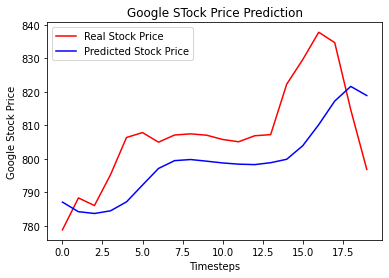

In [18]:
# visualize predictions
plt.plot(real_stock_price, color="red", label="Real Stock Price")
plt.plot(predicted_stock_price, color="blue", label="Predicted Stock Price")
plt.title("Google STock Price Prediction")
plt.xlabel("Timesteps")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()